<figure>
  <img style="float: left;" src="./figures/unine.png" width="200"/>
</figure>

<figure>
  <img style="float: left;" src="./figures/fair_1.png" width="200"/>
</figure>

# Fairness

Machine learning (ML) usage is increasing every day. Companies and Organisation build ML model with the perpuse of minimize the humman efford or improve performance in varius task. So ML is arguably affects our lives directly or not.

Examples:
1. Recomendation system
2. Candidate selection e.x college admitions, CV screening
3. Loan admitions
4. Estimate the propability if someone commits a crime.

There are a lot of examples that research demostrate inadvertently discriminating against several polulation groups. The most know is the reaserch Public Republica in Compas Dataset.

When machine learning models are being used to make decisions, they cannot be separated from the social and ethical context in which they are applied, and those developing and deploying these models must take care to do so in a manner that accounts for both performance and fairness. 

So the last decade Fairness is becomes one of the most active reachard areas in ML.

# A2. Causes of Unfair Models

Bias may be introduced into a machine learning project at any step along the way and it is important to carefully think through each potential source and how it may affect your results. 

ML bias comes directly from our words dataset.
Essentially, this bias comes from human bias existing in training dataset due to historical reasons.

Source of bias:
- Data
    1. Historical injustice.
    2. Collection bias.
    3. Limited features.
    4. Unbalance dataset.
    5. Proxy Variables.
- Modeling
    1. Data preprossesing 
    2. Model assumptions 
- Feedback loops.
    1. desitions based on biased model lead to biased dataset.

# A3. Load Dataset

https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"

In [3]:
def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binarize target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)
    
    # Categorical dataset
    categorical_features = data.select_dtypes('category').columns
    data[categorical_features] = data.select_dtypes('category').apply(lambda x: x.cat.codes)
    return data

### load & clean dataset

In [4]:
# get and clean train dataset
TRAIN_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
train_data = train_data.dropna()
print("Train dataset shape:", train_data.shape)

# get and clean test dataset
TEST_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))
test_data = test_data.dropna()
print("Test dataset shape:", test_data.shape)

Train dataset shape: (28938, 14)
Test dataset shape: (15175, 14)


### data analysis

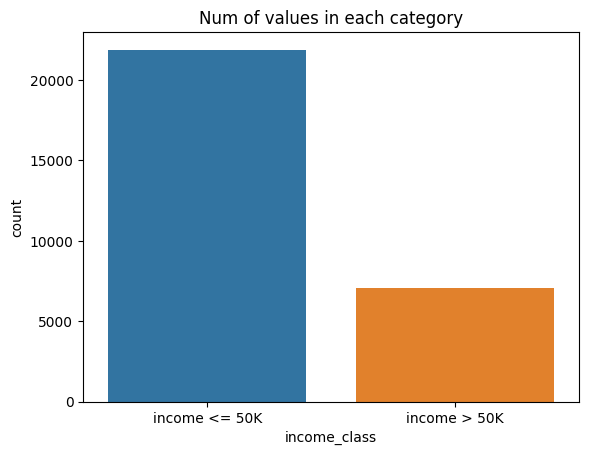

In [5]:
plt.figure()
fig = sns.countplot(x=train_data["income_class"])
fig.set_xticklabels(['income <= 50K','income > 50K'])
plt.title("Num of values in each category")
plt.show()
plt.close()

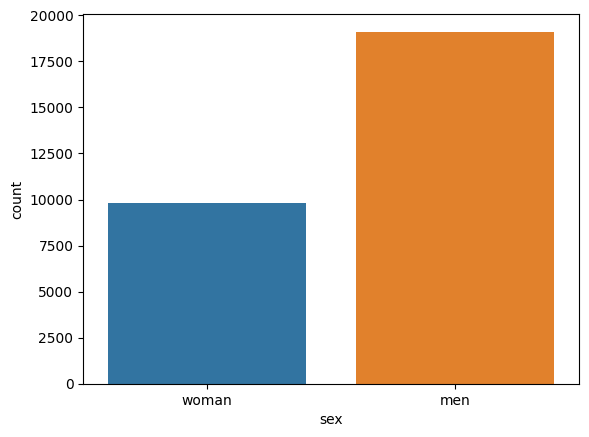

In [8]:
plt.figure()
fig = sns.countplot(x=train_data["sex"])
fig.set_xticklabels(['woman','men'])
# plt.title("gender")
plt.show()
plt.close()

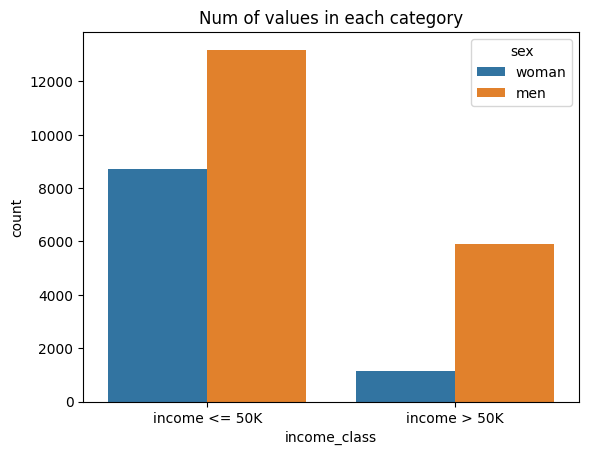

In [6]:
plt.figure()
fig = sns.countplot(data=train_data[["income_class","sex"]],
                    x="income_class",
                    hue="sex")

fig.set_xticklabels(['income <= 50K','income > 50K'])
plt.legend(title='sex', labels=['woman', 'men'])
plt.title("Num of values in each category")
plt.show()
plt.close()

The dataset is quite imbalance between gender, so we expect our model to be unfair.  
The source of the bias is comming from our sosietal bias.

# A4. Train a Model
lets train our model and analyse the results.

In [9]:
features = train_data.columns.difference([target_column])

# we difine sex as our sensitive feature
sensitive_feature = ["sex"]

# all the rest are non senstitive feature
non_sensitive_features = list(set(features).difference(set(sensitive_feature)))

In [10]:
from sklearn.ensemble import RandomForestClassifier

model  = RandomForestClassifier(n_estimators=1000,
                                max_depth=10)

model.fit(X = train_data[sensitive_feature+non_sensitive_features],
          y = train_data[target_column])

RandomForestClassifier(max_depth=10, n_estimators=1000)

# Mesure perfomance scores

<div>
<img style="float: left;" src="./figures/conf_matrix.png" width="300"/>
</div>


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [12]:
conf_matrix = confusion_matrix(y_true = test_data[target_column],
                               y_pred = model.predict(test_data[sensitive_feature+non_sensitive_features]))
conf_matrix = pd.DataFrame(conf_matrix)

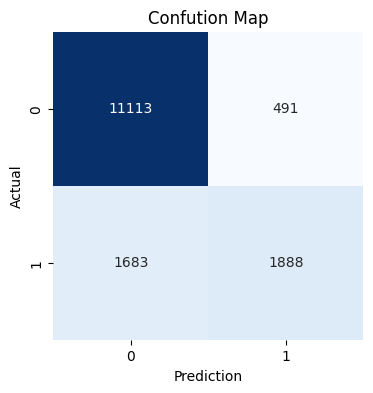

In [13]:
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cbar=False, cmap="Blues")
plt.title("Confution Map")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [14]:
TN, FP, FN, TP = conf_matrix.values.ravel()

acc_score = ( TN + TP ) / (TN + FP + FN + TP)
precision_score = TP / (TP + FP)
recall_score = TP / (TP + FN)
f1_score = 2*(precision_score*recall_score)/(precision_score+recall_score)
print("accuracy score:", acc_score)
print("precision score:", precision_score)
print("recall score:", recall_score)
print("f1 score:", recall_score)

accuracy score: 0.8567380560131795
precision score: 0.7936107608238756
recall score: 0.5287034444133296
f1 score: 0.5287034444133296


In [15]:
acc_score = accuracy_score(y_true = test_data[target_column],
                           y_pred = model.predict(test_data[sensitive_feature+non_sensitive_features]))
print("Accuracy_score:", acc_score)

Accuracy_score: 0.8567380560131795


# A5. Analysis of model fairness


Unfortunatly there is not a sigle defition of fairness.There are many different, often competing, ways to measure whether a given model is statistically “fair” but it’s important to remember to start from the social and policy goals for equity and fairness and map those to the statistical properties we want in our models to help achieve those goals. Most of the definitions involve splitting the population into groups and compare metrics on those groups. 

Different definition preserve different fairness aspects. So the disired fairness definition is depenting on the aplication. In general, this requires consideration of the project’s goals and a detailed discussion between the data scientists, decision makers, and those who will be affected by the application of the model.

Bellow we will define the most known fairness definitions.

In [41]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
predictions = pd.Series(predictions,index = test_data.index)
sensitive_atribute = test_data[sensitive_feature[0]]

In [48]:
woman_mask = sensitive_atribute == 0
conf_matrix_0 = confusion_matrix(y_true = test_data.loc[woman_mask,target_column],
                                 y_pred = predictions.loc[woman_mask])
conf_matrix_0 = pd.DataFrame(conf_matrix_0)

In [51]:
man_mask = sensitive_atribute == 1
conf_matrix_1 = confusion_matrix(y_true = test_data.loc[man_mask,target_column],
                                 y_pred = predictions.loc[man_mask])
conf_matrix_1 = pd.DataFrame(conf_matrix_1)

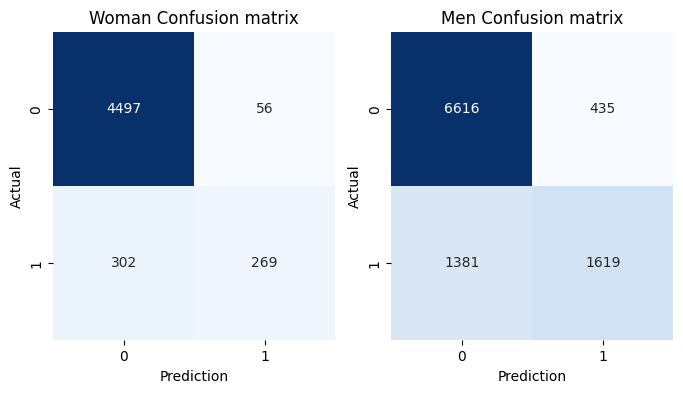

In [64]:
fig, axes = plt.subplots(1, 2, figsize = (8,4))
sns.heatmap(conf_matrix_0, annot=True, fmt='g', cbar=False, cmap="Blues", ax=axes[0])
axes[0].set_title("Woman Confusion matrix")
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Prediction')

sns.heatmap(conf_matrix_1, annot=True, fmt='g', cbar=False, cmap="Blues", ax=axes[1])
axes[1].set_title("Men Confusion matrix")
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Prediction')
plt.show()
plt.close()

## F1.  Demographic Parity

**Demographic parity** , also referred to as **statistical parity** , **acceptance rate parity**  and **benchmarking**

Demographic Parity states that the positive outcome rates between sensitive group must be the same.

---------------
> **Definition Demographic Parity :** A classifire $C$ is said that satisfy **demographic parity** if $$ P_c(\hat{Y}= 1 | S = s ) =  P_c(\hat{Y} = 1), \quad  \forall s\in S $$
in case of 2 sensitive classes, $ s \in \{0,1\}  $ we can also equivalent write:
$$ P_c(\hat{Y}= 1 | S = 0 ) =  P_c(\hat{Y}= 1 | S = 1 ) $$  
---------------

**How to mesure Demographic parity?**   

we can mesure the Demographic parity using the Demographic parity difference metric.

> **Demographic parity difference :** we can mesure the demographic parity using the next formula: 
  $$  \text{Metric} =  max_s[P_c(\hat{Y}= 1 | S = s )] -  min_s[P_c(\hat{Y}= 1 | S = s )] $$  

In [14]:
def demorgafic_parity_difference(predictions, sesitive_atribute):
    """
    Implemention of demografic parity difference for different groups of sentitive artibute
    1. For each group calculate the propotion of accepted rate.
    2. Find the maximum and the minim group.
    3. Calcaulte the difference.
    """
    # 1. For each group calculate the propotion of accepted rate.
    unique_groups = np.sort(sesitive_atribute.unique())
    propotion_of_accepted_rate = []
    for group in unique_groups:
        pred_group = predictions[sesitive_atribute==group]
        accepted_rate = (pred_group==1).sum() / pred_group.shape[0]
        propotion_of_accepted_rate += [accepted_rate]

    # 2. Find the maximum and the minimum accepted_rate.
    maximum_accepted_rate = max(propotion_of_accepted_rate)
    minimum_accepted_rate = min(propotion_of_accepted_rate)

    # 3. Calcaulte the different.
    difference = maximum_accepted_rate - minimum_accepted_rate
    
    return difference, propotion_of_accepted_rate

In [15]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
sesitive_atribute = test_data["sex"]

In [16]:
demorgafic_metric, rates = demorgafic_parity_difference(predictions, sesitive_atribute)

In [17]:
print(f"Demorgafic parity difference is: {round(demorgafic_metric,5)}")

Demorgafic parity difference is: 0.14162


In [18]:
print(f"The rate of different groups are: {rates}")

The rate of different groups are: [0.06284153005464481, 0.20445726793353894]


---------------
**When to use demographic parity?** 
1. We are aware of **historical biases** that may have affected the quality of our data. E.x not presents of spesific minority in a spesific work.
2. We want to **change the state of our current world to improve it**. For example we want to have equal admitions of different group in a spesific project.


**Potential issues?** 
1. **Lazyness**: We can satisfy demografic parity in we accept random people in group S=0 but qualified people in group  b unless we have the same propotion of positive outcome. We avoid lasyness because classfication is usually perfomred by optimizing an perfomance metric.
2. **Not optimality compatible**: A classifier that satisfy demographic parity is suboptimal, if the dataset demographic parity is not hold.
---------------

## F2. Equalized Opotunities

**Equalized Opotunities** , also referred to as **true positive parity**, **sensitivity**.

Equalized Opotunities states that each group has equal true positive rates.

---------------
> **Definition Equalized Opotunities :** A classifire $C$ is said that satisfy **equalized opotunities** if $$ P_c(\hat{Y} = 1 | S = s, Y = 1 ) =  P_c(\hat{Y} = 1 | Y = 1), \quad  \forall s\in S $$
in case of 2 sensitive classes, $ s \in \{0,1\}  $ we can also equivalent write:
$$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$  
---------------

**How to mesure Equalized Opotunities?**   

we can mesure the equalized Opotunities using the equalized opotunities difference metric.

> **equalized opotunities difference :** we can mesure the equalized opotunities using the next formula: 
  $$  \text{Metric} =  max_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] -  min_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] $$  

In [19]:
def equalized_opotunities_difference(predictions, actual, sesitive_atribute):
    """
    Implemention of equalized opotunities difference for different groups of sentitive artibute
    1. For each group calculate the TPR.
    2. Find the maximum and the minim group.
    3. Calcaulte the difference.
    """
    # 1. For each group calculate the TPR.
    unique_groups = np.sort(sesitive_atribute.unique())
    true_positive_rates = []
    for group in unique_groups:
        pred_group = predictions[sesitive_atribute==group]
        actual_group = actual[sesitive_atribute==group]
        conf_matrix = confusion_matrix(y_true = actual_group,
                                       y_pred = pred_group)
        TN, FP, FN, TP = conf_matrix.ravel()
        
        true_positive_rate = TP / (TP + FN)
        true_positive_rates += [true_positive_rate]

    # 2. Find the maximum and the minimum accepted_rate.
    maximum_tpr = max(true_positive_rates)
    minimum_tpr = min(true_positive_rates)

    # 3. Calcaulte the different.
    difference = maximum_tpr - minimum_tpr
    
    return difference, true_positive_rates

In [20]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
sesitive_atribute = test_data["sex"]
actual = test_data[target_column]

In [21]:
equalized_opotunities_metric, _ = equalized_opotunities_difference(predictions, actual, sesitive_atribute)

In [22]:
print(f"equalized opotunities difference is: {round(equalized_opotunities_metric,5)}")

equalized opotunities difference is: 0.0724


#### TODO

---------------
**When to use equalized opotunities?** 
1. When is a strong emphasis on predicting the positive outcome correctly. e.x college admitions
2. When False Positives are not costly for the stateholder. e.x spam detection

**Potential issues?** 
1. **Lazyness**: We can satisfy demografic parity in we accept random people in group S=0 but qualified people in group  b unless we have the same propotion of positive outcome. We avoid lasyness because classfication is usually perfomred by optimizing an perfomance metric.
2. **Not optimality compatible**: A classifier that satisfy demographic parity is suboptimal, if the dataset demographic parity is not hold.
---------------

## F3. Equalized Odds

**Equalized Odds** , also referred to as

Equalized Odds states that the true posite rates (TPR) and false positive rates (FPR) between sensitive group must be the same.

- TPR = TP / total_positives  = TP / (TP+FN)
- FPR = FP / total_negatives = FP / (FP+TN)
---------------
> **Definition Equalized Odds :** A classifire $C$ is said that satisfy **equalized odds** if $$ P_c(\hat{Y} = 1 | S = s, Y = y ) =  P_c(\hat{Y} = 1 | Y = y), \quad  \forall s\in S, \forall y\in Y $$
in case of 2 sensitive classes, $ s \in \{0,1\}  $ we want to satisfie both:
$$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$ 
and 
$$ P_c(\hat{Y}= 1 | S = 0, Y = 0 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 0 ) $$  
---------------

**How to mesure Equalized Opotunities?**   

we can mesure the equalized Opotunities using the equalized opotunities difference metric.

> **equalized opotunities difference :** we can mesure the equalized opotunities using the next formula:
  $$   \text{Metric} = \text{true_positive_rate_difference} + \text{false_positive_rate_difference}  $$
where
  $$ \text{true_positive_rate_difference} =  max_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] -  min_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] $$ 
  $$ \text{false_positive_rate_difference} =  max_s[P_c(\hat{Y}= 1 | S = s, Y = 0 )] -  min_s[P_c(\hat{Y}= 1 | S = s, Y = 0 )] $$  

In [23]:
def equalized_odds_difference(predictions, actual, sesitive_atribute):
    """
    Implemention of equalized odds difference for different groups of sentitive artibute
    1. For each group calculate the TPR.
    2. Find the maximum and the minim group.
    3. Calcaulte the difference.
    """
    # 1. For each group calculate the TPR.
    unique_groups = np.sort(sesitive_atribute.unique())
    true_positive_rates = []
    false_positive_rates = []
    for group in unique_groups:
        pred_group = predictions[sesitive_atribute==group]
        actual_group = actual[sesitive_atribute==group]
        conf_matrix = confusion_matrix(y_true = actual_group,
                                       y_pred = pred_group)
        TN, FP, FN, TP = conf_matrix.ravel()
        
        true_positive_rate = TP / (TP + FN)
        false_positive_rate = FP / (FP + TN)
        
        true_positive_rates += [true_positive_rate]
        false_positive_rates += [false_positive_rate]

    # 2. Find the maximum and the minimum accepted_rate.
    maximum_tpr = max(true_positive_rates)
    minimum_tpr = min(true_positive_rates)
    
    maximum_fpr = max(false_positive_rates)
    minimum_fpr = min(false_positive_rates)

    # 3. Calcaulte the different.
    difference_tpr = maximum_tpr - minimum_tpr
    difference_fpr = maximum_fpr - minimum_fpr
    difference = difference_tpr + difference_fpr
    
    return difference, (true_positive_rates,false_positive_rates)

In [24]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
sesitive_atribute = test_data["sex"]
actual = test_data[target_column]

In [25]:
equalized_odds_metrics, _ = equalized_odds_difference(predictions, actual, sesitive_atribute)

In [26]:
print(f"equalized odds difference is: {round(equalized_odds_metrics,5)}")

equalized odds difference is: 0.12201


In [27]:
results = pd.DataFrame([acc_score,
                        precision_score,
                        recall_score,
                        f1_score,
                        demorgafic_metric,
                        equalized_opotunities_metric,
                        equalized_odds_metrics], 
                       index = ["accuracy",
                                "precision",
                                "recall",
                                "f1_score",
                                "demorgafic_metric",
                                "equalized_opotunities",
                                "equalized_odds"],
                       columns = ["model"])

#### TODO

---------------
**When to use equalized odds?** 
1. When is a strong emphasis on predicting the positive outcome correctly. e.x college admitions
2. When we strongly care about minimising costly False Positives

**Potential issues?** 
1. **Not optimality compatible**: A classifier that satisfy equalized odds is suboptimal, if the dataset demographic parity is not hold. Its more contraind than the equal oportunities so the effect on perfmonace will be stronger
---------------

For your project you have explain why you choose the spesific fairness critiria.

# B. Build a Fairn classifier

In [28]:
def compute_metric(y_pred, y_true, sensitive_feature):
    
    conf_matrix = confusion_matrix(y_true = y_true,
                                   y_pred = y_pred)
    conf_matrix = pd.DataFrame(conf_matrix)

    TN, FP, FN, TP = conf_matrix.values.ravel()

    acc_score = ( TN + TP ) / (TN + FP + FN + TP)
    precision_score = TP  / (TP + FP)
    recall_score = TP  / (TP + FN)
    f1_score = 2*(precision_score*recall_score)/(precision_score+recall_score)
    
    demorgafic_metric, _ = demorgafic_parity_difference(y_pred,
                                                        sensitive_feature)
    
    equalized_opotunities_metric, _ = equalized_opotunities_difference(y_pred,
                                                                       y_true,
                                                                       sensitive_feature)
    equalized_odds_metrics, _ = equalized_odds_difference(y_pred,
                                                          y_true,
                                                          sensitive_feature)
    
    return {
            "accuracy": acc_score,
            "precision": precision_score,
            "recall": recall_score,
            "f1_score": f1_score,
            "demorgafic_metric": demorgafic_metric,
            "equalized_opotunities" : equalized_opotunities_metric,
            "equalized_odds": equalized_odds_metrics
            }

# B1. Unawareness
A very intutive but wrong solution is to assume that ingoring the sensitive feature we can build a fair classifier.
This aproch is wrong because other feature may be correlete with our sensitive features.

We will build a **Unawareness** classifier and the compare the results with our previus classifier.

In [29]:
from sklearn.ensemble import RandomForestClassifier

unaware_model  = RandomForestClassifier(n_estimators=1000,
                                        max_depth=10)

unaware_model.fit(X = train_data[non_sensitive_features],
                  y = train_data[target_column])

RandomForestClassifier(max_depth=10, n_estimators=1000)

In [30]:
unaware_model.predict(test_data[non_sensitive_features])

array([0, 0, 0, ..., 1, 0, 1])

In [31]:
unaware_metrics = compute_metric(y_pred = unaware_model.predict(test_data[non_sensitive_features]),
                                 y_true = test_data[target_column],
                                 sensitive_feature = test_data["sex"])

In [32]:
unaware_results = pd.DataFrame(unaware_metrics,
                               index = ["unaware_model"]).T

In [33]:
unaware_results

,unaware_model
accuracy,0.856870
precision,0.794031
recall,0.528983
f1_score,0.634958
demorgafic_metric,0.140341
equalized_opotunities,0.062643
equalized_odds,0.112256


## Compare the results of 2 models

In [34]:
all_results = pd.concat([results, unaware_results],axis=1)
all_results

,model,unaware_model
accuracy,0.856738,0.856870
precision,0.793858,0.794031
recall,0.528423,0.528983
f1_score,0.634499,0.634958
demorgafic_metric,0.141616,0.140341
equalized_opotunities,0.072399,0.062643
equalized_odds,0.122013,0.112256


### Conclution
Our conclution is that we are not able to vanish unfairness by excluding sensitive features.  
The reason in that some other feature leak information about our sensitive atribute.

## B.2 Prost prossesing
From the above results we expect that our senstitive feature are correlate with non sensitive feature in our analysis.
We will try to find and exclude also those feature in order to improve our fairness properties.

In [35]:
corr = {}
for f in non_sensitive_features:
    corr[f] =np.corrcoef(test_data[sensitive_feature[0]], test_data[f])[0,1]
corr = np.abs(pd.DataFrame(data=corr, index=["corr"]).T).sort_values(by="corr",ascending = False)

<Figure size 640x480 with 0 Axes>

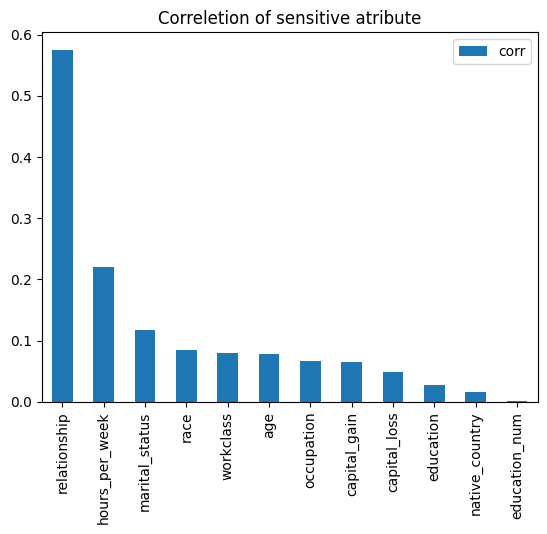

In [36]:
plt.figure()
corr.plot(kind="bar")
plt.title("Correletion of sensitive atribute")
plt.show()
plt.close()

#### bluid classifier excluding k most correleted feature

In [37]:
k=3
k_most_correleted = corr.iloc[0:k].index.values.tolist()

In [38]:
for i in range(len(k_most_correleted)):
    print(f"===========iteration{i+1}===========")
    training_features = list(set(non_sensitive_features).difference(set(k_most_correleted[0:i+1])))
    print("We exclude from training: ", k_most_correleted[0:i+1])
    
    # 1. train
    post_prossesing_model  = RandomForestClassifier(n_estimators=1000,
                                                    max_depth=10)

    post_prossesing_model.fit(X = train_data[training_features],
                              y = train_data[target_column])
    

    # 2. compute metrix
    post_prossesing_metrics = compute_metric(y_pred= post_prossesing_model.predict(test_data[training_features]),
                                             y_true= test_data[target_column],
                                             sensitive_feature = test_data["sex"])
    
    # 3. append result
    post_prossesing_results = pd.DataFrame(post_prossesing_metrics,
                                           index = [f"post_prossesing_{i+1}"]).T
    
    all_results = pd.concat([all_results, post_prossesing_results],axis=1)

===========iteration1===========
We exclude from training:  ['relationship']
===========iteration2===========
We exclude from training:  ['relationship', 'hours_per_week']
===========iteration3===========
We exclude from training:  ['relationship', 'hours_per_week', 'marital_status']


In [39]:
all_results

,model,unaware_model,post_prossesing_1,post_prossesing_2,post_prossesing_3
accuracy,0.856738,0.856870,0.856277,0.853443,0.833806
precision,0.793858,0.794031,0.800086,0.780976,0.843035
recall,0.528423,0.528983,0.518902,0.524223,0.360963
f1_score,0.634499,0.634958,0.629523,0.627346,0.505490
demorgafic_metric,0.141616,0.140341,0.146743,0.141248,0.068148
equalized_opotunities,0.072399,0.062643,0.100674,0.071569,0.027330
equalized_odds,0.122013,0.112256,0.153326,0.122531,0.028113


<AxesSubplot: >

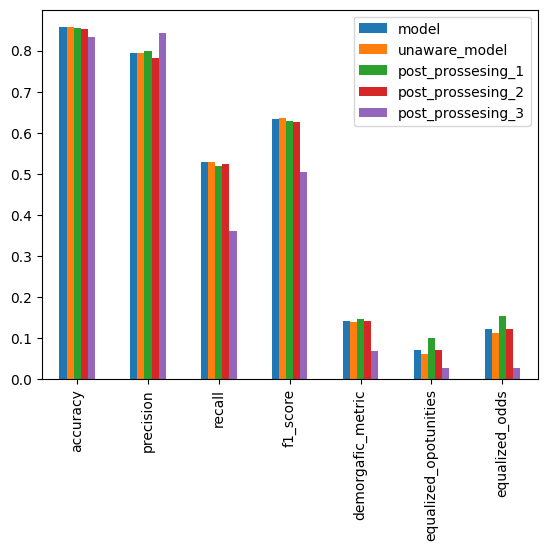

In [40]:
all_results.plot(kind="bar")

In [41]:
all_results

,model,unaware_model,post_prossesing_1,post_prossesing_2,post_prossesing_3
accuracy,0.856738,0.856870,0.856277,0.853443,0.833806
precision,0.793858,0.794031,0.800086,0.780976,0.843035
recall,0.528423,0.528983,0.518902,0.524223,0.360963
f1_score,0.634499,0.634958,0.629523,0.627346,0.505490
demorgafic_metric,0.141616,0.140341,0.146743,0.141248,0.068148
equalized_opotunities,0.072399,0.062643,0.100674,0.071569,0.027330
equalized_odds,0.122013,0.112256,0.153326,0.122531,0.028113


# Post-Processing

In [107]:
propa = model.predict_proba(train_data[sensitive_feature+non_sensitive_features])

In [108]:
ts = np.linspace(0,1,50)

In [118]:
p = propa[:, 1]

In [119]:
p

array([0.08472451, 0.34597013, 0.04282177, ..., 0.33056474, 0.02499307,
       0.95064964])

In [120]:
class_0_mask = p >= t
    
prediction = pd.Series(class_0_mask * 1,index=train_data.index)

In [114]:
class_0_mask

array([False, False, False, ..., False, False, False])

In [113]:
prediction

0        0
1        0
2        0
3        0
4        0
        ..
32554    0
32555    0
32556    0
32558    0
32560    0
Length: 28938, dtype: int64

In [121]:
metric_ts = []
for t in ts:
    class_1_mask = p >= t
    
    prediction = pd.Series(class_1_mask * 1,index=train_data.index)
    
    metrics = compute_metric(y_pred = prediction,
                             y_true = train_data[target_column],
                             sensitive_feature = train_data[sensitive_feature[0]])
    
    metric_ts += [metrics]

/tmp/ipykernel_1085938/3049594467.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)


In [122]:
ts_results = pd.DataFrame(metric_ts,index = ts)

In [132]:
ts_results

,accuracy,precision,recall,f1_score,demorgafic_metric,equalized_opotunities,equalized_odds
0.000000,0.243693,0.243693,1.000000,0.391887,0.000000,0.000000,0.000000
0.020408,0.469245,0.314617,0.999575,0.478596,0.212358,0.000547,0.191501
0.040816,0.583938,0.368958,0.995746,0.538414,0.343087,0.016010,0.330069
0.061224,0.643652,0.405310,0.989365,0.575043,0.384775,0.036865,0.380758
0.081633,0.684740,0.435058,0.983693,0.603296,0.385240,0.045918,0.376564
0.102041,0.712869,0.458225,0.977595,0.623976,0.383906,0.051302,0.371342
0.122449,0.735849,0.479251,0.969512,0.641430,0.386284,0.058538,0.374201
0.142857,0.755408,0.499041,0.959161,0.656508,0.377531,0.069395,0.367704
0.163265,0.769784,0.515012,0.948667,0.667598,0.373748,0.083245,0.371492
0.183673,0.782224,0.530072,0.937323,0.677185,0.366414,0.091866,0.367356


<AxesSubplot: >

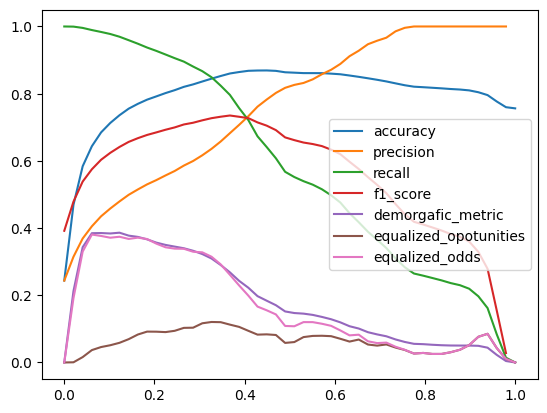

In [133]:
ts_results.plot()

In [134]:
train_data[target_column].value_counts() / train_data[target_column].shape[0]

0    0.756307
1    0.243693
Name: income_class, dtype: float64